In [1]:
# ### mount on google drive
# from google.colab import drive
# drive.mount('/content/drive/')
import os
os.chdir("/content/drive/My Drive/WatNet/notebooks")


In [2]:
import os
os.chdir('..')
import time
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from utils.geotif_io import readTiff, writeTiff
from utils.acc_pixel import acc_matrix
from utils.imgPatch import imgPatch
from model.seg_model.watnet import watnet
from utils.imgShow import imgShow,imsShow
import glob


In [3]:
## test image and test sample
paths_s2_img = sorted(glob.glob('data/data-poyang/*2019????.tif'))
print(paths_s2_img)
paths_pred = []
for i in range(len(paths_s2_img)):
    path_pred = paths_s2_img[i].split('.')[0]+'_pred.tif'
    paths_pred.append(path_pred)
print(paths_pred)


['data/data-poyang/sen2_20190127.tif', 'data/data-poyang/sen2_20190313.tif', 'data/data-poyang/sen2_20190407.tif', 'data/data-poyang/sen2_20190512.tif', 'data/data-poyang/sen2_20190626.tif', 'data/data-poyang/sen2_20190731.tif', 'data/data-poyang/sen2_20190820.tif', 'data/data-poyang/sen2_20190929.tif', 'data/data-poyang/sen2_20191019.tif', 'data/data-poyang/sen2_20191108.tif', 'data/data-poyang/sen2_20191213.tif']
['data/data-poyang/sen2_20190127_pred.tif', 'data/data-poyang/sen2_20190313_pred.tif', 'data/data-poyang/sen2_20190407_pred.tif', 'data/data-poyang/sen2_20190512_pred.tif', 'data/data-poyang/sen2_20190626_pred.tif', 'data/data-poyang/sen2_20190731_pred.tif', 'data/data-poyang/sen2_20190820_pred.tif', 'data/data-poyang/sen2_20190929_pred.tif', 'data/data-poyang/sen2_20191019_pred.tif', 'data/data-poyang/sen2_20191108_pred.tif', 'data/data-poyang/sen2_20191213_pred.tif']


In [5]:
# ### show the image and prediction
# for i in range(len(paths_pred)):
#     print(paths_s2_img[i])
#     sen2_img, img_info = readTiff(path_in=paths_s2_img[i])
#     pred_img, pred_info = readTiff(path_in=paths_pred[i])
#     img_list = [sen2_img, pred_img]
#     img_name = ['sen2_image','water_prediction']
#     col_bands_list=[[4,3,2], [0,0,0]]
#     clip_list=[5,0]
#     plt.figure(figsize=(20,12))
#     imsShow(img_list=img_list, img_name_list=img_name, clip_list=clip_list, color_bands_list=col_bands_list)
#     plt.show()
#     del sen2_img, pred_img


In [4]:
# pre-trained model
path_model = 'model/pretrained/watnet.h5'
## super parameters
patch_size = 512
overlay = 80  # the overlay area between neighboring patches

data/data-poyang/sen2_20191213.tif
data/data-poyang/sen2_20191213_pred.tif


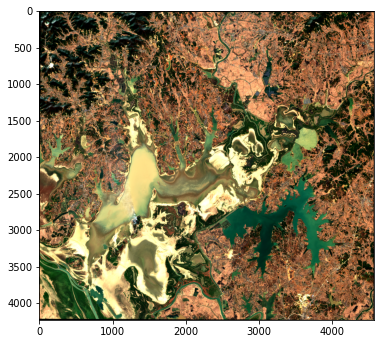

In [41]:
# -----Load and prepare the satellite image data -----#
id_img = 10
sen2_img, img_info = readTiff(path_in=paths_s2_img[id_img])
sen2_img = np.float32(np.clip(sen2_img/10000, a_min=0, a_max=1))  ## normalization
print(paths_s2_img[id_img])
print(paths_pred[id_img])
plt.figure(figsize=(6,6))
imgShow(sen2_img, clip_percent=5)


In [42]:
###  ----- load the pretrained model -----#
model = watnet(input_shape=(512, 512, 6), nclasses=2)
# model = deeplabv3_plus(nclasses=2, input_shape=(512, 512, 6))
# model = deepwatermapv2(min_width=4)
model.load_weights(path_model)


*** Building DeepLabv3Plus Network ***
*** Output_Shape => (None, 512, 512, 1) ***


In [43]:
## surface water mapping from sentinel-2 image
with tf.device('/device:GPU:0'):
    imgPatch_ins = imgPatch(sen2_img, patch_size, overlay)
    patch_list, start_list, img_patch_row, img_patch_col = imgPatch_ins.toPatch()
    result_patch_list = [model(patch[np.newaxis, :]) for patch in patch_list]
    result_patch_list = [np.squeeze(patch, axis = 0) for patch in result_patch_list]
    pro_map = imgPatch_ins.toImage(result_patch_list, img_patch_row, img_patch_col)
    cla_map = np.where(pro_map>0.5, 1, 0)


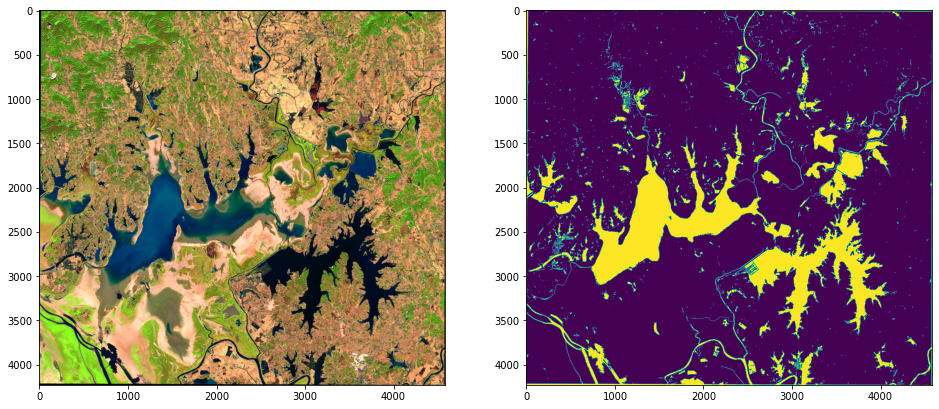

In [44]:
### show the result
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
imgShow(sen2_img, color_bands=[4,3,2])
plt.subplot(1,2,2)
imgShow(cla_map)


### Save the result.

In [45]:
# # save the result
writeTiff(im_data=cla_map.astype(np.int8), \
          im_geotrans=img_info['geotrans'], \
          im_geosrs=img_info['geosrs'], \
          path_out = paths_pred[id_img])
